In [62]:
import numpy as np
import pandas as pd
import collections
import itertools
import matplotlib.pyplot as plt
import pickle
import time
import copy

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime, date, timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [63]:
def convert_str2time(x): 
    '''conver time to the structure form
    output: (year, mon, day, hour, min, sec, wday, yday, isdst)
    '''
    return time.strptime(x, "%Y-%m-%d %H:%M:%S")

def match_ip_freq(freq, df):
    '''
    map ip to ip_counts according to 
    freq (pandas.Series): with index=ip and value=counts
    '''
    def match_ip(x, freq):
        try:
            return freq.loc[x]
        except:
            return 0
    return df.assign(ip_counts = (df['ip'].apply(lambda x: match_ip(x, freq)).values))


def bin_class_train(df, categorical_list, threshold_rare):
    '''
    bin rare classes and add one unknown class (0) in case there are new classes in test
    categorical_list (list): all categorical variables for binning 
    threshold_rare (list): threshold of rare classes for each categorical variable
    '''
    num_classes = []
    rare = []
    com = []
    for i in range(len(categorical_list)):
        col = categorical_list[i]
        threshold = threshold_rare[i]
        categ = df[col]
        categ_count = categ.value_counts()
        rare_class =set(categ_count[categ_count.values<threshold].index.values)
        rare.append(rare_class)
        com_class = list(categ_count[categ_count.values>=threshold].index.values)
        com.append(com_class)
        n_class = len(com_class)
        if len(rare_class) != 0: #rare class is the last class
            n_class += 1
            categ = categ.apply(lambda x: n_class if x in rare_class else com_class.index(x)+1)
        else:
            categ = categ.apply(lambda x: com_class.index(x)+1)
        num_classes.append(n_class+1) #add one class for 'unknown'  
        df[col] = categ.values
    return df, num_classes, rare, com

def bin_class_test(df, categorical_list, threshold_rare, num_classes, rare, com):
    '''
    bin class in test based on training sets
    categorical_list (list): all categorical variables for binning 
    threshold_rare (list): threshold of rare classes for each categorical variable
    num_classes (list): the number of classes for each categorical variable
    rare (list of sets): index of rare classes for each categorical variable
    com (list of lists): index of common classes for each caregorical variable
    '''
    def get_class(x, com_class):
        try:
            return com_class.index(x)+1
        except:
            return 0
    for i in range(len(categorical_list)):
        col = categorical_list[i]
        tsh = threshold_rare[i]
        categ = df[col]
        n_class = num_classes[i]
        rare_class = rare[i]
        com_class = com[i]
        if len(rare_class) != 0:
            categ = categ.apply(lambda x: n_class-1 if x in rare_class else get_class(x, com_class))
        else:
            categ = categ.apply(lambda x: get_class(x, com_class)) 
        df[col] = categ.values
    return df

In [64]:
def get_train_feature(df, categorical_list, threshold_rare):
    '''
    get train features
    categorical_list (list): all categorical variables for binning 
    threshold_rare (list): threshold of rare classes for each categorical variable
    '''
    #ip_counts
    freq_ip = df['ip'].value_counts() #Series: from ip to count
    df = match_ip_freq(freq_ip, df) #get ip_counts
    #binning rare classes and one-hot-encoder
    df, num_classes, rare, com = bin_class_train(df, categorical_list, threshold_rare)
    enc = OneHotEncoder(n_values=np.array(num_classes))
    enc.fit(df[categorical_list])
    names = [] #names for dummy variables
    for i, cl in enumerate(enc.n_values_):
        names += [categorical_list[i]+str(j) for j in range(cl)]
    categ_dummy = enc.transform(df[categorical_list]).toarray()
    categ_dummy = pd.DataFrame(categ_dummy, columns=names)

    # deal with click_time
    time_stru = df['click_time'].apply(convert_str2time)
    # categorical variables used for the click_time attribute
    categ_time = ['hour', ]
    stru_dict = {'year': 0, 'mon': 1, 'day': 2, 'hour': 3, 'min': 4, 'wday': 6, 'yday': 7 }
    col = categ_time[0]
    h_arr = time_stru.apply(lambda x: x[stru_dict[col]]).values.reshape(-1,1)
    enc_time = OneHotEncoder(n_values=24)
    enc_time.fit(h_arr)
    h_dummy = enc_time.transform(h_arr).toarray()
    h_dummy = pd.DataFrame(h_dummy, columns=['h_'+str(i) for i in range(24)])
  
    df.reset_index(drop=True, inplace=True)
    df = df.drop(['click_time', 'ip']+categorical_list, axis=1)
    df = pd.concat((df, categ_dummy, h_dummy), axis=1)
    feature_engineer = {'Freq_ip': freq_ip, 'OneHotEncoder_categorical':enc, 
                        'Num_classes': num_classes, 'Names_categorical': names,
                        'RareClass': rare, 'CommonClass': com, 
                        'OneHotEncoder_time': enc_time }
                    
    return df, feature_engineer

In [65]:
def get_test_features(df, categorical_list, threshold_rare, feature_engineer):
    '''
    get test features 
    categorical_list (list): all categorical variables for binning 
    threshold_rare (list): threshold of rare classes for each categorical variable
    feature_engineer (dictionary): information to transform the test dataset 
    '''
    freq_ip = feature_engineer['Freq_ip']
    enc = feature_engineer['OneHotEncoder_categorical']
    num_classes = feature_engineer['Num_classes']
    names = feature_engineer['Names_categorical']
    rare = feature_engineer['RareClass']
    com = feature_engineer['CommonClass']
    enc_time = feature_engineer['OneHotEncoder_time']
    df = match_ip_freq(freq_ip, df)
    df = bin_class_test(df, categorical_list, threshold_rare, num_classes, rare, com)
    categ_dummy = enc.transform(df[categorical_list]).toarray()
    categ_dummy = pd.DataFrame(categ_dummy, columns=names)

    # deal with click_timecfc
    time_stru = df['click_time'].apply(convert_str2time)
    # categorical variables used for the click_time attribute
    categ_time = ['hour', ]
    stru_dict = {'year': 0, 'mon': 1, 'day': 2, 'hour': 3, 'min': 4, 'wday': 6, 'yday': 7 }
    col = categ_time[0]
    h_arr = time_stru.apply(lambda x: x[stru_dict[col]]).values.reshape(-1,1)
    h_dummy = enc_time.transform(h_arr).toarray()
    h_dummy = pd.DataFrame(h_dummy, columns=['h_'+str(i) for i in range(24)])
    
    df.reset_index(drop=True, inplace=True)
    df = df.drop(['click_time', 'ip']+categorical_list, axis=1)
    df = pd.concat((df, categ_dummy, h_dummy), axis=1)
    return df

In [66]:
class TimeDependentEnsembler():
    def __init__(self, classifier_name, dependency_length, dependency_weight_decay, hyperparam,
                train_feature_engineering_function, test_feature_engineering_function,
                categorical_features, rare_category_threshold):
        """
        Constructor
        
        classifier_name (String): classifier we use for each model, either "dicision tree" or "random forest"
        dependency_length (int): number of models we use in emsembler
        dependency_weight_decay (float): decay rate for the weight of previous models
        hyperparam (dict): hyperparameters for each model
        train_feature_engineering_function (func): function used for feature engineering on train set
        test_feature_engineering_function (func): function used for feature engineering on test set
        model_queue (deque): a queue to store functions used for emsembling
        dict_queue (deque): a queue to store dicts used for feature engineering
        categorical_features (list): feature (names) that should be considered as categorical feature
        rare_category_threshold (list): threshold for a category to be considered rare in the corresponding feature
        """
        if classifier_name != "decision tree" and classifier_name != "random forest":
            raise ValueError("Unidentified classifier name, only decision tree and random forest are allowed")
        self.classifier_name = classifier_name
        self.dependency_length= dependency_length
        self.dependency_weight_decay = dependency_weight_decay
        self.hyperparam = hyperparam
        self.train_feature_engineering_function = train_feature_engineering_function
        self.test_feature_engineering_function = test_feature_engineering_function
        self.model_queue = collections.deque()
        self.dict_queue = collections.deque()
        self.categorical_features = categorical_features
        self.rare_category_threshold = rare_category_threshold
        
    def alter_hyperparam(self, new_hyperparam):
        """
        Change hyperparam used for future classifiers
        """
        self.hyperparam = new_hyperparam
        
    def add_new_model(self, X, y):
        """
        Given X and y as train set, train a new model and push it to the end of queue
        
        X (np array): train features
        y (np array): train labels
        """
        new_classifier = None
        # Expand the hyperparam block if needed
        if self.classifier_name == "random forest":
            new_classifier = RandomForestClassifier(n_estimators = self.hyperparam.get("n_estimators", 10), 
                                                    criterion = self.hyperparam.get("criterion", "gini"), 
                                                    max_depth = self.hyperparam.get("max_depth", None),
                                                    min_samples_split = self.hyperparam.get("min_samples_split", 2),
                                                    class_weight = self.hyperparam.get("class_weight", None))
        else:
            new_classifier = DecisionTreeClassifier(criterion = self.hyperparam.get("criterion", "gini"),
                                                    max_depth = self.hyperparam.get("max_depth", None),
                                                    min_samples_split = self.hyperparam.get("min_samples_split", 2),
                                                    class_weight = self.hyperparam.get("class_weight", None))
        # Feature engineering on train set
        X, cur_dict = self.train_feature_engineering_function(X, self.categorical_features, 
                                                              self.rare_category_threshold)
        new_classifier.fit(X, y)
        self.model_queue.appendleft(new_classifier)
        self.dict_queue.appendleft(cur_dict)
        if len(self.model_queue) > self.dependency_length:
            self.model_queue.popleft()
            self.dict_queue.popleft()
        return self
            
    def pred_proba(self, X):
        """
        Given test set X (which is not being feature engineered), generate prediction for X
        
        X (np array): test features
        
        return: class probability matrix: (num_instances, 2)
        """
        total_weight = 0
        cur_weight = 1
        # Here we assume it's a binary classification
        total_pred = np.array([[0.0, 0.0] for _ in range(X.shape[0])])
        for i in range(len(self.model_queue) - 1, -1, -1):
            X_cur = copy.deepcopy(X)
            X_cur = self.test_feature_engineering_function(X_cur, self.categorical_features, 
                                                           self.rare_category_threshold,
                                                           self.dict_queue[i])
            # Potential optimization here: use 3d matrix to store all preds and reduce at the end
            total_pred += self.model_queue[i].predict_proba(X_cur) * cur_weight
            total_weight += cur_weight
            cur_weight *= self.dependency_weight_decay
        return total_pred / total_weight

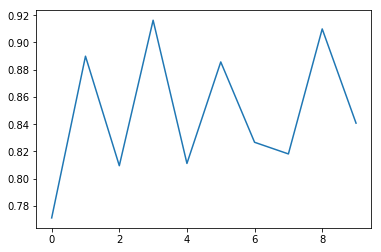

In [67]:
hyperparam = {"class_weight": "balanced"}
categorical_features = ['app', 'device', 'os', 'channel']
rare_category_threshold = [50, 50, 50, 50]
TDE = TimeDependentEnsembler(classifier_name = "random forest", dependency_length = 5, 
                             dependency_weight_decay = 0.8, hyperparam = hyperparam, 
                             train_feature_engineering_function = get_train_feature,
                             test_feature_engineering_function = get_test_features, 
                             categorical_features = categorical_features, 
                             rare_category_threshold = rare_category_threshold)
auc_record = []
# Num of points in a batch
batch_len = 10000
# Num of batches as train set for a single model
batches_as_train = 10
# Starting row
begin = 0
for i in range(10):
    cur_data = pd.read_csv('/Users/daoyangshan/DSGA1003/train_tail.csv', skiprows = range(1, begin + i * batch_len), 
                           nrows = batch_len * (batches_as_train + 1))
    cur_y = cur_data['is_attributed']
    cur_X = cur_data.drop(['attributed_time', 'is_attributed'], axis = 1)
    X_train, X_test = cur_X.iloc[:batch_len * batches_as_train + 1], cur_X.iloc[batch_len * batches_as_train + 1:]
    y_train, y_test = cur_y.iloc[:batch_len * batches_as_train + 1], cur_y.iloc[batch_len * batches_as_train + 1:]
    TDE.add_new_model(X_train, y_train)
    cur_pred = TDE.pred_proba(X_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, cur_pred[:, 1])
    auc_record.append(metrics.auc(fpr, tpr))
    
plt.figure()
plt.plot(auc_record)
plt.show()